<a href="https://colab.research.google.com/github/sebcalcagno/AnalisisSeriesTemporales/blob/main/CLASE_6/AST_Clase_6_ejercicio_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modelos ADL (Autoregressive Distributed Lag) = Los regresores pueden incluir valores retrasados ​​de la variable dependiente y valores actuales y retrasados ​​de una o más variables explicativas. 

In [ ]:
# Importar los módulos necesarios para la generación de datos
import numpy as np

#Importe los módulos necesarios para la creación de gráficos:
import matplotlib.pyplot as plt

#Importe los módulos requeridos para la creación de DataFrame:
import pandas as pd

#Importar los módulos necesarios para la generación de datos de TimeSeries:
import statsmodels.api as sm

#Importar los módulos requeridos para el cálculo de estadísticas de prueba:
import statsmodels.stats as sm_stat

#Importe los módulos necesarios para la estimación del modelo:
import statsmodels.tsa as smt

#Importe los módulos necesarios para la optimización
import scipy.optimize as optimize

#También necesitamos datos adicionales:
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
url='https://raw.githubusercontent.com/sebcalcagno/AnalisisSeriesTemporales/main/serie-tiempo-indicadores-mensuales-bovinos.csv'

serie = pd.read_csv(url, index_col='indice_tiempo', parse_dates=True)

serie = serie.asfreq('MS') # Frecuencia mensual

In [ ]:
serie.head()

,faena_total_pais,porcentaje_hembras,produccion_en_miles_de_toneladas_res_con_hueso,peso_promedio_res,novillos_precio_kilo_vivo_pesos,novillo_precio_kilo_vivo_dolares,novillos_peso_kilo_vivo,consumo_interno_aparente_en_miles_de_toneladas_res_c_hueso,consumo_interno_per_capita_kg_por_habitante,consumo_interno_per_capita_kg_por_habitante_por_anio,exportacion_volumen_en_toneladas_equivalentes_res_con_hueso,exportacion_valor_en_miles_de_dolares,exportacion_por_toneladas_res_con_hueso
indice_tiempo,,,,,,,,,,,,,
1998-01-01,981503,41.82,215.20,219.25,1.00,1.00,448.0,191.23,62.79,64.11,26785.94,54865.43,2048.29
1998-02-01,889530,43.02,191.89,215.72,1.07,1.07,447.0,169.56,61.58,63.85,25146.46,50791.64,2019.83
1998-03-01,992968,43.24,211.44,212.94,1.09,1.09,441.0,190.18,62.32,63.80,24082.90,50331.92,2089.94
1998-04-01,936164,42.03,200.01,213.65,1.11,1.11,441.0,176.69,59.78,62.77,26138.69,56388.48,2157.28
1998-05-01,912879,42.83,193.45,211.91,1.14,1.14,440.0,174.36,57.04,62.05,21904.65,48956.00,2234.96


In [ ]:
serie=serie.drop(['novillos_precio_kilo_vivo_pesos','novillo_precio_kilo_vivo_dolares','novillos_peso_kilo_vivo','faena_total_pais','porcentaje_hembras','produccion_en_miles_de_toneladas_res_con_hueso','peso_promedio_res','consumo_interno_aparente_en_miles_de_toneladas_res_c_hueso','consumo_interno_per_capita_kg_por_habitante_por_anio','exportacion_volumen_en_toneladas_equivalentes_res_con_hueso','exportacion_valor_en_miles_de_dolares'], axis=1)  


In [ ]:
serie.head()   

,consumo_interno_per_capita_kg_por_habitante,exportacion_por_toneladas_res_con_hueso
indice_tiempo,,
1998-01-01,62.79,2048.29
1998-02-01,61.58,2019.83
1998-03-01,62.32,2089.94
1998-04-01,59.78,2157.28
1998-05-01,57.04,2234.96


<Figure size 432x288 with 0 Axes>

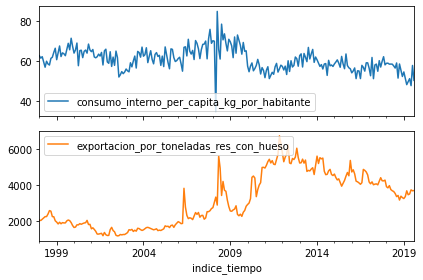

In [ ]:
fig = plt.figure()
serie.plot(subplots=True, layout=(2,1))
plt.legend()
plt.tight_layout()
plt.show()

Dado que se trata de datos de series temporales, es probable que las noticias del mes anterior sobre el consumo interno por capita por habitante afecten las exportaciones. Como tal, es necesario incluir rezagos de X en la regresión.

A continuación, presentamos las estimaciones de OLS de los coeficientes en un modelo de rezago distribuido en el que se permite que la exportacion_por_toneladas_res_con_hueso dependa de el consumo interno per capita (kg por habitantelas) hasta qmax=3 <br> export por toneladas = α +β0⋅consumo interno + β1⋅ consumo interno t−1 + β2⋅ consumo interno t−2 + β3⋅ consumo interno t−3 +ϵt 

In [ ]:
def lag(x, n):
    if n == 0:
        return x
    if isinstance(x, pd.Series):
        return x.shift(n) 
    else:
        x = pd.Series(x)
        return x.shift(n) 

    x = x.copy()
    x[n:] = x[0:-n]
    x[:n] = np.nan
    return x

In [ ]:
mod_L1_est = smf.ols(formula = 'exportacion_por_toneladas_res_con_hueso ~ 1 + lag(consumo_interno_per_capita_kg_por_habitante, 0) +  lag(consumo_interno_per_capita_kg_por_habitante, 1) +  lag(consumo_interno_per_capita_kg_por_habitante, 2) + lag(consumo_interno_per_capita_kg_por_habitante, 3) ', data = serie)     
mod_L1_fit = mod_L1_est.fit()
print(mod_L1_fit.summary())

                                       OLS Regression Results                                      
Dep. Variable:     exportacion_por_toneladas_res_con_hueso   R-squared:                       0.210
Model:                                                 OLS   Adj. R-squared:                  0.197
Method:                                      Least Squares   F-statistic:                     16.71
Date:                                     Sat, 23 Jul 2022   Prob (F-statistic):           3.69e-12
Time:                                             15:32:21   Log-Likelihood:                -2208.2
No. Observations:                                      257   AIC:                             4426.
Df Residuals:                                          252   BIC:                             4444.
Df Model:                                                4                                         
Covariance Type:                                 nonrobust                                         


Dado que el valor p correspondiente a la variable explicativa consumo en t0 y t-1 es mayor que 0,05, no podemos rechazar la hipótesis nula al nivel de significación del 5%. En consecuencia, eliminamos estas variables del modelo y volvemos a estimar el modelo considerando estas observaciones, lo que arroja los siguientes resultados:

In [ ]:
mod_L2_est = smf.ols(formula = 'exportacion_por_toneladas_res_con_hueso ~ 1 + lag(consumo_interno_per_capita_kg_por_habitante, 2) + lag(consumo_interno_per_capita_kg_por_habitante, 3)', data = serie)     
mod_L2_fit = mod_L2_est.fit()
print(mod_L2_fit.summary())

                                       OLS Regression Results                                      
Dep. Variable:     exportacion_por_toneladas_res_con_hueso   R-squared:                       0.200
Model:                                                 OLS   Adj. R-squared:                  0.194
Method:                                      Least Squares   F-statistic:                     31.78
Date:                                     Sat, 23 Jul 2022   Prob (F-statistic):           4.79e-13
Time:                                             15:33:28   Log-Likelihood:                -2209.7
No. Observations:                                      257   AIC:                             4425.
Df Residuals:                                          254   BIC:                             4436.
Df Model:                                                2                                         
Covariance Type:                                 nonrobust                                         


In [ ]:
print(np.round(mod_L2_fit.params, 2))
print(np.round(mod_L2_fit.pvalues, 4))

Intercept                                              11370.15
lag(consumo_interno_per_capita_kg_por_habitante, 2)      -69.39
lag(consumo_interno_per_capita_kg_por_habitante, 3)      -65.46
dtype: float64
Intercept                                              0.0000
lag(consumo_interno_per_capita_kg_por_habitante, 2)    0.0000
lag(consumo_interno_per_capita_kg_por_habitante, 3)    0.0001
dtype: float64


La ecuacion resultante es la siguiente =

exportacion_precio_dolares_por_toneladas_res_con_hueso t = 11370.15 - 69.39 consumo_interno_per_capita_kg_por_habitante t-2   -  65.46 consumo_interno_per_capita_kg_por_habitante t-3

La interpretación es : aumentar el consumo interno de carne en 1 en un mes determinado t está asociado con: <br> Una reducción inmediata en la exportacion_por_toneladas_res_con_hueso de 69.39 dos meses despues;  <br>
Una reducción inmediata en la exportacion_por_toneladas_res_con_hueso de 65.46 tres meses despues;